In [61]:
import torch 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, ConfusionMatrixDisplay
import matplotlib.pyplot as plt 

In [154]:
len(H_raw_train)/len(H_raw_test)

1.836639292482628

In [149]:
H_raw_train = np.array(np.load('../data/processed_data/H_train_data.npy'))
MDD_raw_train = np.array(np.load('../data/processed_data/MDD_train_data.npy'))
H_raw_test = np.array(np.load('../data/processed_data/H_test_data.npy'))
MDD_raw_test = np.array(np.load('../data/processed_data/H_test_data.npy'))

X_train = np.array([x.ravel() for x in np.vstack((H_raw_train, MDD_raw_train))])
X_test = np.array([x.ravel() for x in np.vstack((H_raw_test, MDD_raw_test))])
y_train = np.hstack((np.zeros(len(H_raw_train)), np.ones(len(MDD_raw_train))))
y_test = np.hstack((np.zeros(len(H_raw_test)), np.ones(len(MDD_raw_test))))



In [ ]:
## NOT splitting train-test by subject ==> leakage
# H_raw = np.array(np.load('../data/processed_data/H_data.npy'))
# MDD_raw = np.array(np.load('../data/processed_data/MDD_data.npy'))

# X = np.array([x.ravel() for x in np.vstack((H_raw, MDD_raw))])
# y = np.hstack((np.zeros(len(H_raw)), np.ones(len(MDD_raw))))


# X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)

In [150]:
model = MLPClassifier([361, 50, 2], activation = 'relu', solver = 'adam',
            batch_size = 32, early_stopping = True, learning_rate = 'adaptive'
)

model.fit(X_train, y_train)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = np.mean(train_pred == y_train)
test_acc = np.mean(test_pred == y_test)

print('Train Accuracy: ', train_acc, '\nTest Accuracy: ', test_acc)


Train Accuracy:  0.9873618184076512 
Test Accuracy:  0.5


              precision    recall  f1-score   support

         0.0       0.50      0.87      0.64      7915
         1.0       0.50      0.13      0.20      7915

    accuracy                           0.50     15830
   macro avg       0.50      0.50      0.42     15830
weighted avg       0.50      0.50      0.42     15830



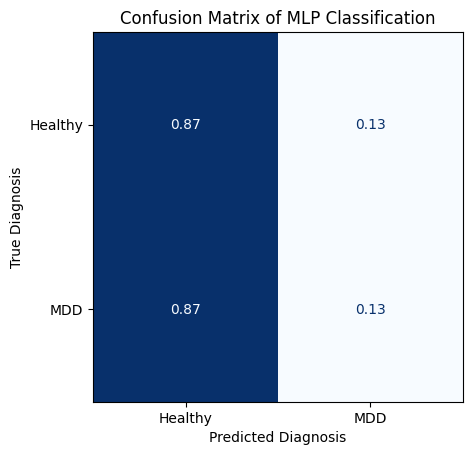

In [151]:
print(classification_report(y_test, test_pred))
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=['Healthy', 'MDD'],
        cmap=plt.cm.Blues,
        normalize='true',
        colorbar = False
    )
disp.confusion_matrix
plt.title('Confusion Matrix of MLP Classification')
plt.xlabel('Predicted Diagnosis')
plt.ylabel('True Diagnosis')
plt.show()

_Can try now with removing the diagonal from the matrices and retraining model. Then reconstructing matrices_

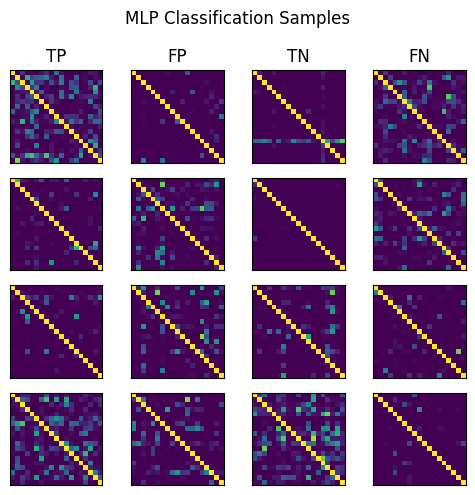

In [152]:
# misclassification analysis
TP = np.where((y_test == test_pred) & (test_pred ==1))[0]
TN = np.where((y_test == test_pred) & (test_pred == 0))[0]
FP = np.where((y_test != test_pred) & (test_pred == 1))[0]
FN = np.where((y_test != test_pred) & (test_pred == 0))[0]

TP_GC = X_test[np.random.choice(TP, 4)].reshape(4,19,19)
TN_GC = X_test[np.random.choice(TN, 4)].reshape(4,19,19)
FP_GC = X_test[np.random.choice(FP, 4)].reshape(4,19,19)
FN_GC = X_test[np.random.choice(FN, 4)].reshape(4,19,19)

fig, axs = plt.subplots(4, 4, figsize=(5,5))

for i, tp in enumerate(TP_GC):
    ax = axs[i][0]
    if i == 0:
        ax.set_title('TP')
    ax.imshow(tp)
    ax.set_xticks(())
    ax.set_yticks(())

for i, fp in enumerate(FP_GC): 
    ax = axs[i][1]
    if i == 0:
        ax.set_title('FP')
    ax.imshow(fp)
    ax.set_xticks(())
    ax.set_yticks(())

for i, tn in enumerate(TN_GC):
    ax = axs[i][2]
    if i == 0:
        ax.set_title('TN')
    ax.imshow(tn)
    ax.set_xticks(())
    ax.set_yticks(())
    
for i, fn in enumerate(FN_GC):
    ax = axs[i][3]
    if i == 0:
        ax.set_title('FN')
    ax.imshow(fn)
    ax.set_xticks(())
    ax.set_yticks(())

plt.suptitle('MLP Classification Samples')
plt.tight_layout()
plt.show()